# ADM - Homework 4 - Movie Recommendation System
## Group-3 members
### 1.  Noah BOULEDROUA (2181745)
### 2.  Nudo Luca (2027873)
### 3.  Ghulam Mujtaba (2184696)
### 4.  Dario Datola (Missing)

## 1. Recommendation System with LSH
#### In this section, you will implement a recommendation system by identifying users with similar preferences and suggesting movies based on their behavior. Specifically, you will implement your version of the LSH algorithm.

In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/movielens-20m-dataset


In [4]:
movie = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
rating = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')


## 1.1 Data Preparation
#### Download the MovieLens dataset from here. After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

In [5]:

#Dictionnary to have the films seen by all users (keys : user_id, values: films seen)
user_movies = rating.groupby('userId')['movieId'].apply(set).to_dict() 

## 1.2 Minhash Signatures
#### Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

#### Important: 
Implement your MinHash function from scratch—do not use any pre-built hash functions.
Use your MinHash function to generate signature vectors for each user based on their rated movies.
Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.
Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

In [6]:
import random

#With this function we generate the hashing functions 
def hashing_functions(n, max): # "n" is the number of hashing functions and "max" the maximum values of the coefficient of the functions
    hashing_functions = []
    for k in range(n):
        a, b = random.randint(1, max), random.randint(0, max)
        hashing_functions.append(lambda x, a=a, b=b: (a * x + b) % max)
    return hashing_functions

# With this function we compute the minhash signatures for each user
def minhash_signatures(user_movies, hashing_functions):
    signatures = []
    for h in hashing_functions:
        min_hash = min(h(movie) for movie in user_movies)
        signatures.append(min_hash)
    return signatures

## 1.3 Locality-Sensitive Hashing (LSH)
#### Now that you have generated MinHash user signatures, apply Locality-Sensitive Hashing (LSH) to cluster similar users.

#### 1. Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

#### Debugging Tip: After creating buckets, check a few bucket contents to verify that multiple users are being grouped in the same buckets.

In [8]:

# With this function we apply Locality-Sensitive Hashing (LSH) to cluster similar users
def lsh(user_signatures, n_bands, modulo): # "n_bands" is the number of bands we want in the signature of each users
    rows_in_band = n // n_bands
    buckets = [{} for k in range(n_bands)] 
    
    for user, signature in user_signatures.items():
        for i in range(n_bands):
            
            #Find the values of the i-th band 
            start = i * rows_in_band
            end = start + rows_in_band
            band = tuple(signature[start:end])  
            
            #Hash the band to generate a bucket ID
            bucket_id = hash(band) % modulo
            
            # Add the user to the corresponding bucket
            if bucket_id not in buckets[i]:
                buckets[i][bucket_id] = []
            buckets[i][bucket_id].append(user)
    
    return buckets


#### Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

In [9]:

#With this function we find the two most similar users of a user
def find_similar_users(user_id, buckets, n_bands):
    similar_users = {}
    
    # Find the users in the same bucket as our user (user_id)
    for k in range(n_bands):
        for bucket_id, users in buckets[k].items():
            if user_id in users:
                for other_user in users:
                    if other_user != user_id:
                        similar_users[other_user] = similar_users.get(other_user, 0) + 1
    
    # Compute Jaccard similarity for each similar user
    user_movies_set = user_movies[user_id] 
    jaccard_similarities = {}
    for user in similar_users:
        similar_user_movies_set = user_movies[user]
        intersection = len(user_movies_set & similar_user_movies_set)
        union = len(user_movies_set | similar_user_movies_set)
        if union > 0:
            jaccard_similarities[other_user] = intersection / union

    #Sort by decreasing Jaccard similarity
    sorted_users = sorted(jaccard_similarities.items(), key=lambda x: x[1], reverse=True)
    
    #Return the two most similar users
    return [user for user, similarity in sorted_users[:2]]


### Movie Recommendation Logic:

If both similar users have rated a movie, recommend this movie based on the average rating.
If there are no commonly rated movies, recommend the top-rated movies of the most similar user.

In [10]:

#With this function we generate films recommendations based on the ratings of the films seen by the similar user
def recommend_movies(user_id, similar_users):
    recommendations = {}
    
    #Stock ratings of similar users for films our user (user_id) has not seen
    for similar_user in similar_users:
        for mov in user_movies[similar_user]:
            if mov not in user_movies[user_id]:  
                if mov not in recommendations:
                    recommendations[mov] = []
                rating_value = rating[(rating['userId'] == similar_user) & (rating['movieId'] == mov)]['rating'].values
                if rating_value.size > 0:
                    recommendations[mov].append(rating_value[0])
                    
    #Compute the average rating for each films 
    averaged_recommendations = {mov: sum(rating) / len(rating) 
                                for mov, rating in recommendations.items()}

    #Return the top 5 based on the average ratings
    sorted_recommendations = sorted(averaged_recommendations.items(), key=lambda x: x[1], reverse=True)
    return [movie[movie['movieId']== int(mov_id)]['title'].values[0] for mov_id, i in sorted_recommendations[:5]]
    


#### Example recommendation logic for a user:

| User | Movie Title   | Rating |
|------|---------------|--------|
| A    | Inception     | 4.5    |
| A    | Titanic       | 4.2    |
| A    | Avatar        | 2.8    |
| B    | Inception     | 4.6    |
| B    | The Matrix    | 3.9    |
| B    | Toy Story     | 4.7    |
| C    | Titanic       | 3.8    |
| C    | Avatar        | 4.3    |
| C    | Shrek         | 4.1    |

### Example Recommendation Logic

If User A and User B are identified as the two most similar users to User X, the recommended movies would be:

1. **Common Movies**: "Inception" (average rating: 4.55).
2. **Top-rated from Most Similar User**: "Toy Story" (4.7) from User B and "Titanic" (4.2) from User A.
3. If fewer than 5 movies are found, complete the list using other high-rated movies by the most similar users.


In [12]:
if __name__ == "__main__":

    user_id = int(input("Choose a user ID"))

    n = 100
    max = rating['movieId'].max()
    
    hash_functions = hashing_functions(n, max)

    user_signatures = {user: minhash_signatures(movies, hash_functions)
                   for user, movies in user_movies.items()}
    
    n_bands = 20 
    modulo = 10007 
    
    buckets = lsh(user_signatures, n_bands,modulo)

    similar_users = find_similar_users(user_id, buckets, n_bands)

    mov_recommended = recommend_movies(user_id, similar_users)

    print("Recommended movies :", mov_recommended)

Choose a user ID 213


Recommended movies : ['Down Periscope (1996)', 'Milk Money (1994)', 'Serial Mom (1994)', 'Son in Law (1993)', 'Beautician and the Beast, The (1997)']


## 2. Grouping Movies Together!

As you know, the dataset provided isn’t particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

movieid id of each movie

genres list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)

ratings_avg the average ratings provided by users for the movie

relevant_genome_tag the most relevant tag to the movie given in the genome set

common_user_tag the most common tag given to the movie by the users


In [1]:
import pandas as pd
import numpy as np

In [2]:
genome_scores = pd.read_csv("genome_scores.csv")
genome_tags = pd.read_csv("genome_tags.csv")
links = pd.read_csv("link.csv")
movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv")
tags = pd.read_csv("tag.csv") 

In [3]:

# Feature 1: movieId - Already exists in all relevant files
movies_features = movies[['movieId']].copy()

# Feature 2: Genres - Transform genres into separate binary features
genres_list = set()
movies['genres'].str.split('|').apply(genres_list.update)
genres_list = sorted(genres_list)

for genre in genres_list:
    movies_features[genre] = movies['genres'].str.contains(genre).astype(int)

# Feature 3: Average Rating (ratings_avg)
ratings_avg = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings_avg.rename(columns={'rating': 'ratings_avg'}, inplace=True)
movies_features = movies_features.merge(ratings_avg, on='movieId', how='left')

# Feature 4: Relevant Genome Tag - Tag with highest relevance for each movie
relevant_tag = genome_scores.loc[genome_scores.groupby('movieId')['relevance'].idxmax()]
relevant_tag = relevant_tag.merge(genome_tags, on='tagId', how='left')[['movieId', 'tag']]
relevant_tag.rename(columns={'tag': 'relevant_genome_tag'}, inplace=True)
movies_features = movies_features.merge(relevant_tag, on='movieId', how='left')

# Feature 5: Most Common User Tag - Most frequently used tag for each movie

common_user_tag = tags.groupby(['movieId', 'tag']).size().reset_index(name='count')
common_user_tag = common_user_tag.loc[common_user_tag.groupby('movieId')['count'].idxmax()]
common_user_tag.rename(columns={'tag': 'common_user_tag'}, inplace=True)
movies_features = movies_features.merge(common_user_tag[['movieId', 'common_user_tag']], on='movieId', how='left')



C:\Users\user\AppData\Local\Temp\ipykernel_6012\3429886646.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies_features[genre] = movies['genres'].str.contains(genre).astype(int)


In addition to the above features, include at least three additional features for clustering.

Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.

In [4]:

# Additional Features
# Feature 6: Number of Ratings
num_ratings = ratings.groupby('movieId')['rating'].count().reset_index()
num_ratings.rename(columns={'rating': 'number_of_ratings'}, inplace=True)
movies_features = movies_features.merge(num_ratings, on='movieId', how='left')

# Feature 7: Rating Variance
rating_variance = ratings.groupby('movieId')['rating'].var().reset_index()
rating_variance.rename(columns={'rating': 'rating_variance'}, inplace=True)
movies_features = movies_features.merge(rating_variance, on='movieId', how='left')

# Feature 8: Tag Diversity Movies with more tags might appeal to diverse audiences or cover broader themes
tag_diversity = tags.groupby('movieId')['tag'].nunique().reset_index()
tag_diversity.rename(columns={'tag': 'tag_diversity'}, inplace=True)
movies_features = movies_features.merge(tag_diversity, on='movieId', how='left')

## Why more than eight features?
#### The reason we have more than eight features is primarily due to the one-hot encoding of the genres column. Each movie can belong to multiple genres, and these genres were originally represented as a single, pipe-separated string (e.g., "Action|Adventure|Comedy").

#### So, to better represent the genres for clustering, the genres column was split into multiple binary columns—one for each unique genre. Thus we have now more than eight features. 

### Cleaning data to fill out missing values before moving to part 2.2 of Q#-2  

In [5]:
countCols=0
for col in movies_features.columns:
    countCols+=1
    if movies_features[col].isnull().sum()>0:
        print(f"ColName: {col}   {movies_features[col].isnull().sum()}")
print(f"total columns: {countCols}")

ColName: ratings_avg   534
ColName: relevant_genome_tag   16897
ColName: common_user_tag   7733
ColName: number_of_ratings   534
ColName: rating_variance   4506
ColName: tag_diversity   7733
total columns: 27


In [6]:
movies_features['ratings_avg'].fillna(movies_features['ratings_avg'].mean(), inplace=True) # Filling mising values with mean
movies_features['relevant_genome_tag'].fillna('Unknown', inplace=True) # Fill 'relevant_genome_tag' with a placeholder 'Unknown'
movies_features['common_user_tag'].fillna('None', inplace=True) # Fill 'relevant_genome_tag' with a placeholder 'None'
movies_features['number_of_ratings'].fillna(0, inplace=True) # (assuming no ratings means 0 ratings)
movies_features['rating_variance'].fillna(0, inplace=True) # (assuming no ratings leads to 0 variance)
movies_features["tag_diversity"].fillna(movies_features["tag_diversity"].mean(), inplace=True)


## 2.2 Choose your features (variables)!
With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?


1.  What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?

### Answer:
Normalization is important because it ensures all features contribute equally to clustering, preventing larger-scale features like num_ratings from dominating. It improves distance calculations, which clustering algorithms like K-means rely on, and helps algorithms converge faster. Without normalization, clustering results may become skewed and less meaningful.


##### 2.  If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.

In [7]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['ratings_avg', 'number_of_ratings', 'rating_variance', 'tag_diversity']
scaler = StandardScaler()
movies_features[numerical_features] = scaler.fit_transform(movies_features[numerical_features])


#### 3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

##### Answer:
Dimensionality reduction is the process of reducing the number of features (or dimensions) in a dataset while retaining as much meaningful information as possible. This helps simplify data analysis and improves the efficiency of algorithms.

### Effective Techniques for Reducing Features in the MovieLens Dataset.
#### Principal Component Analysis (PCA):

Why Effective: PCA consolidates correlated features, such as one-hot encoded genres and numerical features, into a smaller set of uncorrelated components. It reduces redundancy and retains most of the dataset's variance, making it suitable for clustering and improving computational efficiency.

#### t-SNE (t-Distributed Stochastic Neighbor Embedding):

Why Effective: While not used for preprocessing, t-SNE is excellent for visualizing clusters in 2D or 3D by preserving local relationships between data points. This can provide insights into how movies are naturally grouped.

#### Manual Feature Selection:
Why Effective: Selecting only the most relevant features, such as ratings_avg, tag_diversity, and key numerical features, simplifies the dataset without requiring transformations. This method is interpretable and computationally efficient.


#### 4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.


Applying the PCA method with 95% variance of data in dataset


In [8]:
from sklearn.decomposition import PCA

# Exclude non-numeric columns and identifiers
excluded_columns = ['movieId', 'relevant_genome_tag', 'common_user_tag']
numeric_features = [col for col in movies_features.columns if col not in excluded_columns]

data_for_PCA = movies_features[numeric_features]

# Applying PCA to retain 95% of variance
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(data_for_PCA)

# Output dimensions
print(f"Original dimensions: {data_for_PCA.shape}")
print(f"Reduced dimensions: {reduced_data.shape}")


Original dimensions: (27278, 24)
Reduced dimensions: (27278, 14)


## 2.3 Clustering
### Now that you have prepared the data, you can create the clusters.

#### 1.  How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.

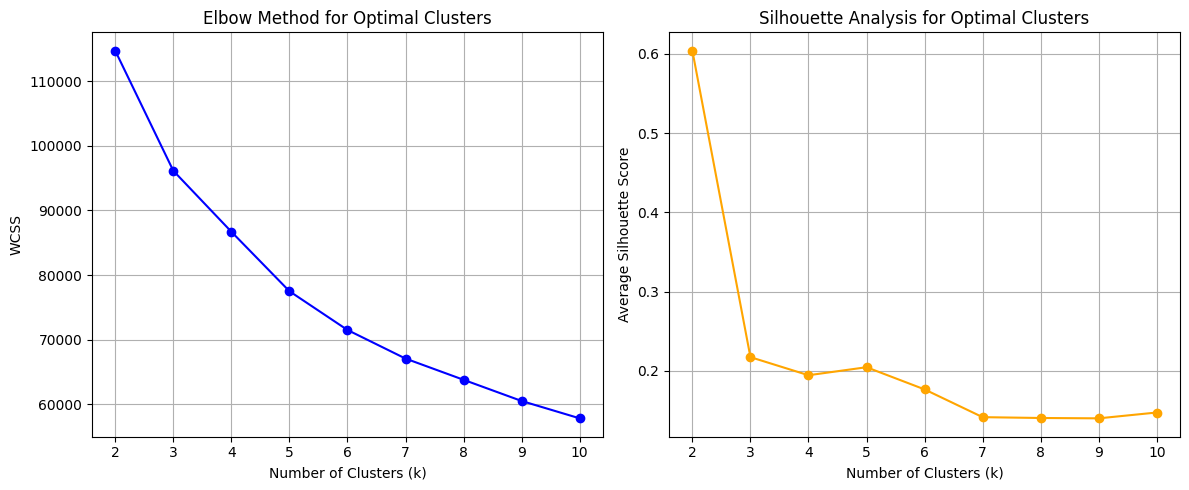

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Initialize variables for analysis
wcss = []  # Within-cluster sum of squares for Elbow Method
silhouette_scores = []  # Silhouette scores for each k

# Range of cluster numbers to evaluate
k_values = range(2, 11)

for k in k_values:
    # Fit K-means model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_data)
    
    # Append WCSS
    wcss.append(kmeans.inertia_)
    
    # Append Silhouette Score
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  


axes[0].plot(k_values, wcss, marker='o', color='blue')
axes[0].set_title('Elbow Method for Optimal Clusters')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)

axes[1].plot(k_values, silhouette_scores, marker='o', color='orange')
axes[1].set_title('Silhouette Analysis for Optimal Clusters')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Average Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()



#### Remarks:
### To determine the optimal number of clusters, two methods were applied:

### Elbow Method:
The Elbow Method revealed a clear "elbow" at k=4, where the Within-Cluster Sum of Squares (WCSS) starts to show diminishing returns.
This suggests that 4 clusters provide a good balance between model complexity and the variance explained.

### Silhouette Analysis:
The Silhouette Scores for different values of k were also analyzed. The highest average silhouette score was observed at k=2, but the score remains reasonably high for k=4 while capturing more structure in the data.

### Conclusion:
Based on the Elbow Method and Silhouette Analysis, the optimal number of clusters for this dataset is k=4, as it balances interpretability and quality of clustering.

### Implementation of K-means through MapReducer

In [10]:
import numpy as np

def initialize_centroids(data, k):
    np.random.seed(42)  
    indices = np.random.choice(len(data), k, replace=False)
    return data[indices]

def mapper(data, centroids):
    cluster_points = {}
    for idx, point in enumerate(data):
        distances = np.linalg.norm(point - centroids, axis=1) 
        cluster_id = np.argmin(distances)  
        if cluster_id not in cluster_points:
            cluster_points[cluster_id] = []
        cluster_points[cluster_id].append(point) 
    return cluster_points

def reducer(cluster_points):
    new_centroids = []
    for cluster_id, points in cluster_points.items():
        new_centroids.append(np.mean(points, axis=0))
    return np.array(new_centroids)

def kmeans_mapreduce(data, k, max_iters=100, tolerance=1e-4):
    centroids = initialize_centroids(data, k)  
    for i in range(max_iters):
        cluster_points = mapper(data, centroids)
        new_centroids = reducer(cluster_points)

        if np.linalg.norm(new_centroids - centroids) < tolerance:
            print(f"K-means converged in {i+1} iterations.")
            break
        centroids = new_centroids
    return centroids, cluster_points

### running the algorithm on our data and visualizing it.

K-means converged in 63 iterations.


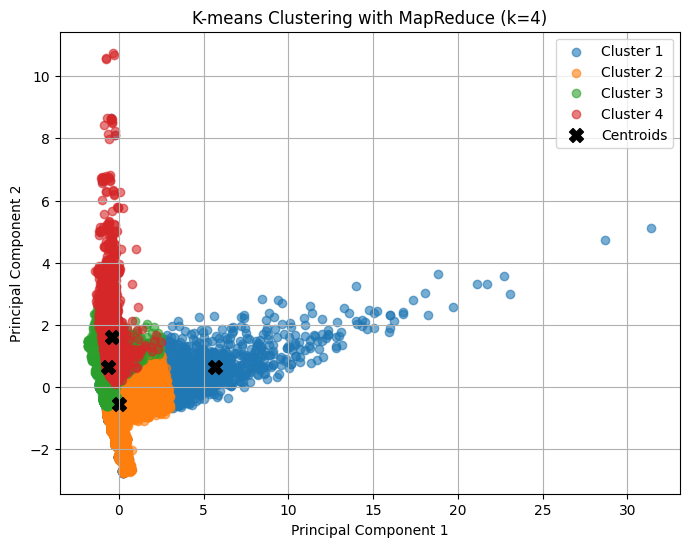

In [11]:
k = 4 # clusters

# Apply K-means MapReduce
centroids, cluster_points = kmeans_mapreduce(reduced_data, k)

labels = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0] 
        labels[idx] = cluster_id

# Plot clustered data
plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    cluster_points = reduced_data[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id+1}', alpha=0.6)

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='X', s=100, label='Centroids')

plt.title('K-means Clustering with MapReduce (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

### Silhouette Score Calculation for K-means

In [27]:
from sklearn.metrics import silhouette_score

# Run K-means
k = 4  
centroids_kmeans, cluster_points_kmeans = kmeans_mapreduce(reduced_data, k)

# Assign cluster labels for silhouette calculation
labels_kmeans = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points_kmeans.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        labels_kmeans[idx] = cluster_id

# Calculate Silhouette Score
silhouette_kmeans = silhouette_score(reduced_data, labels_kmeans)
print(f"Silhouette Score for K-means: {silhouette_kmeans:.3f}")


K-means converged in 63 iterations.
Silhouette Score for K-means: 0.122


#### 3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Initialize centroids using K-means++
def initialize_centroids_kmeanspp(data, k):
    """Initialize centroids using K-means++ logic."""
    np.random.seed(42)  # Ensure reproducibility
    n_points = data.shape[0]
    centroids = [data[np.random.choice(n_points)]]

    for _ in range(1, k):
        distances = np.min([np.linalg.norm(data - c, axis=1)**2 for c in centroids], axis=0)
        probabilities = distances / np.sum(distances) 
        next_centroid_idx = np.random.choice(n_points, p=probabilities)
        centroids.append(data[next_centroid_idx])
    
    return np.array(centroids)

def mapper(data, centroids):
    """Assign each point to the nearest centroid."""
    cluster_points = {}
    for idx, point in enumerate(data):
        distances = np.linalg.norm(point - centroids, axis=1)  
        cluster_id = np.argmin(distances) 
        if cluster_id not in cluster_points:
            cluster_points[cluster_id] = []
        cluster_points[cluster_id].append(point) 
    return cluster_points

def reducer(cluster_points):
    """Compute new centroids as the mean of assigned points."""
    new_centroids = []
    for cluster_id, points in cluster_points.items():
        new_centroids.append(np.mean(points, axis=0)) 
    return np.array(new_centroids)

def kmeans_kmeanspp(data, k, max_iters=100, tolerance=1e-4):
    """K-means clustering with K-means++ initialization."""
    centroids = initialize_centroids_kmeanspp(data, k)
    
    for i in range(max_iters):
        cluster_points = mapper(data, centroids)
        new_centroids = reducer(cluster_points)
        if np.linalg.norm(new_centroids - centroids) < tolerance:
            print(f"K-means++ converged in {i+1} iterations.")
            break
        centroids = new_centroids
    
    return centroids, cluster_points

K-means++ converged in 23 iterations.


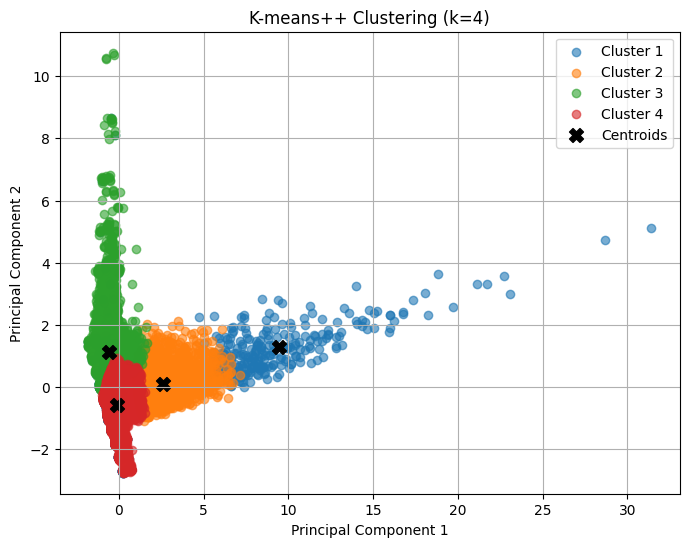

In [13]:
k = 4  # Number of clusters
centroids_kmeanspp, cluster_points_kmeanspp = kmeans_kmeanspp(reduced_data, k)

labels_kmeanspp = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points_kmeanspp.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        labels_kmeanspp[idx] = cluster_id

plt.figure(figsize=(8, 6))
for cluster_id in range(k):
    cluster_points = reduced_data[labels_kmeanspp == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id+1}', alpha=0.6)

plt.scatter(centroids_kmeanspp[:, 0], centroids_kmeanspp[:, 1], color='black', marker='X', s=100, label='Centroids')

plt.title('K-means++ Clustering (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


## Silhouette Score Calculation for K-means++

In [28]:
# Run K-means++
centroids_kmeanspp, cluster_points_kmeanspp = kmeans_kmeanspp(reduced_data, k)

# Assign cluster labels for silhouette calculation
labels_kmeanspp = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points_kmeanspp.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        labels_kmeanspp[idx] = cluster_id

# Calculate Silhouette Score
silhouette_kmeanspp = silhouette_score(reduced_data, labels_kmeanspp)
print(f"Silhouette Score for K-means++: {silhouette_kmeanspp:.3f}")


K-means++ converged in 23 iterations.
Silhouette Score for K-means++: 0.136


### Why These Differences Occur
#### Random Initialization in K-means:
##### Centroids are chosen randomly, and if they are poorly positioned, the algorithm takes longer to adjust. This can lead to more iterations, with the algorithm potentially converging to a local minimum.
#### K-means++ Initialization:
##### K-means++ ensures centroids are spread out by selecting them probabilistically based on distances from existing centroids. This reduces the likelihood of initial centroids being too close together, leading to faster convergence and better-defined clusters.

#### 4. Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

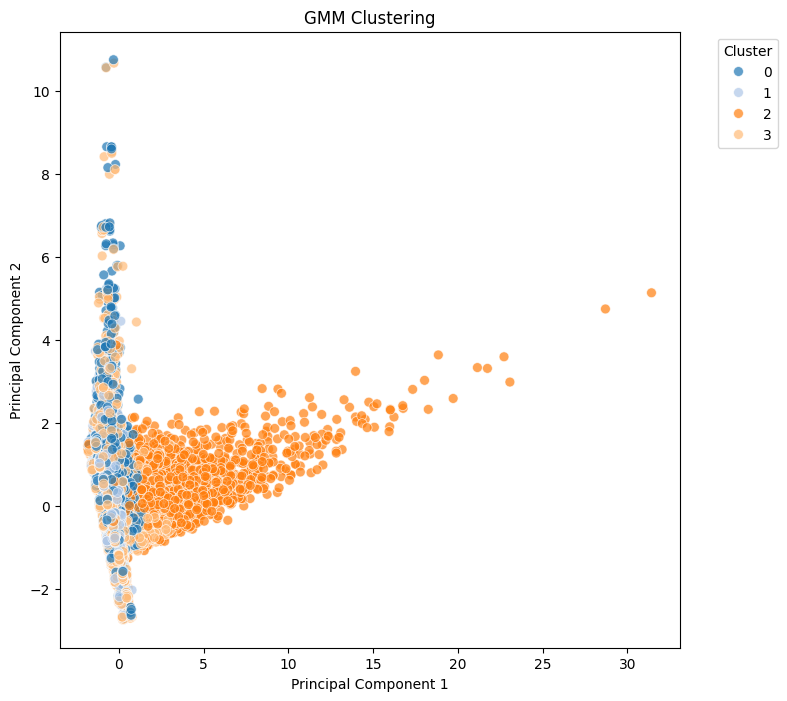

Cluster probabilities for the first 5 data points:
[[0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 9.80936553e-157]
 [1.66736588e-291 0.00000000e+000 1.79398362e-005 9.99982060e-001]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000 8.26070697e-141]]


In [19]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Fit a GMM with a chosen number of clusters
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)  # Choose n_components = 4 for now
gmm.fit(reduced_data)

# Step 2: Predict cluster labels and probabilities
gmm_labels = gmm.predict(reduced_data)
gmm_probs = gmm.predict_proba(reduced_data)  # Soft clustering probabilities

# Step 3: Visualize clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=gmm_labels, palette="tab20", s=50, alpha=0.7)
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 4: Print cluster probabilities for the first few data points (optional)
print("Cluster probabilities for the first 5 data points:")
print(gmm_probs[:5])


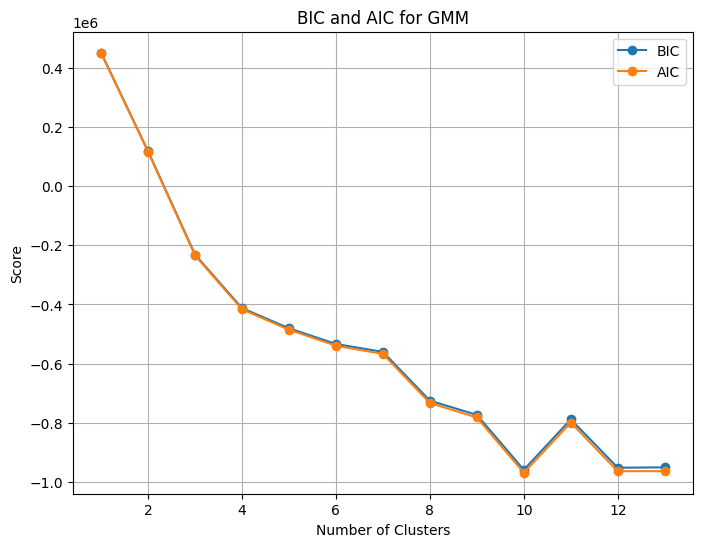

In [ ]:
# Determine the optimal number of clusters using BIC and AIC
bic = []
aic = []
n_components = range(1, 10)  # Test cluster numbers from 1 to 10

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(reduced_data)
    bic.append(gmm.bic(reduced_data))
    aic.append(gmm.aic(reduced_data))

# Plot BIC and AIC
plt.figure(figsize=(8, 6))
plt.plot(n_components, bic, label='BIC', marker='o')
plt.plot(n_components, aic, label='AIC', marker='o')
plt.title('BIC and AIC for GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


### Having 6-clusters as optimal for GMM, we use it.

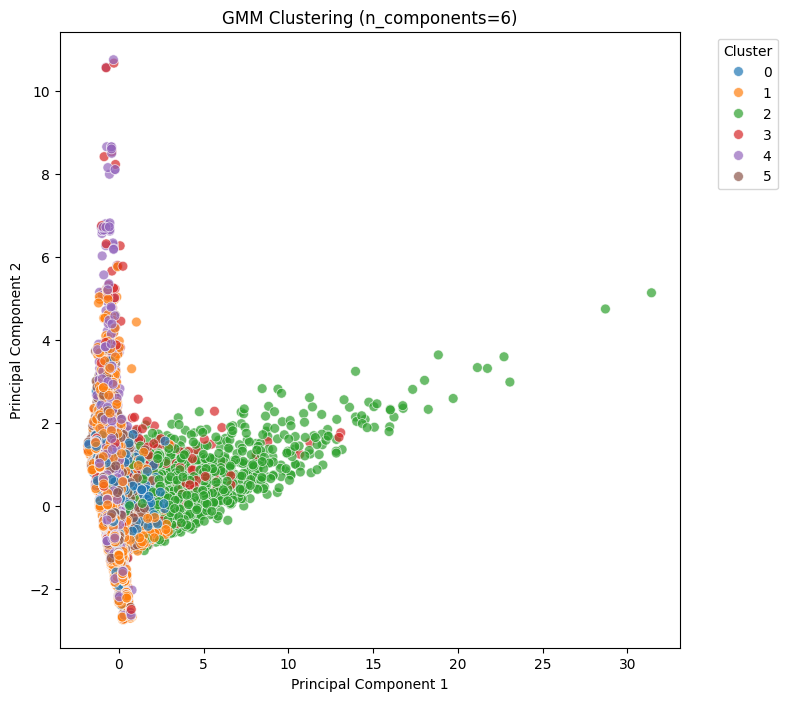

In [22]:
# Fit GMM with n_components=6
gmm = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm.fit(reduced_data)

# Predict cluster labels
gmm_labels = gmm.predict(reduced_data)

# Visualize GMM clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=gmm_labels, palette="tab10", s=50, alpha=0.7)
plt.title('GMM Clustering (n_components=6)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [29]:
from sklearn.metrics import silhouette_score

# Check convergence
if gmm.converged_:
    print(f"GMM converged in {gmm.n_iter_} iterations.")
else:
    print("GMM did not converge.")

# Silhouette score for GMM
silhouette_gmm = silhouette_score(reduced_data, gmm_labels)
print(f"Silhouette Score for GMM: {silhouette_gmm:.3f}")


GMM converged in 54 iterations.
Silhouette Score for GMM: 0.024


##Result's Comparison

| **Method**      | **Convergence Iterations** | **Silhouette Score** | **Cluster Shape** | **Notes**                                    |
|------------------|----------------------------|-----------------------|-------------------|---------------------------------------------|
| **K-means**      | 63                        | 0.122                 | Spherical          | Sensitive to initialization.                |
| **K-means++**    | 23                        | 0.136                 | Spherical          | Faster convergence due to better initialization. |
| **GMM**          | 54                        | 0.024                 | Elliptical         | Allows for soft clustering and flexible shapes. |



##### K-means++ performed the best with a silhouette score of 0.136, compared to K-means (0.122) and GMM (0.024). K-means++ achieved faster convergence in 23 iterations, thanks to smarter centroid initialization, while K-means required 63 iterations. GMM converged in 54 iterations but struggled to form well-separated clusters, likely due to overlapping or elliptical clusters not aligning well with the dataset’s structure.

##### Both K-means and K-means++ assume spherical clusters, which suited the MovieLens dataset better after PCA reduction. In contrast, GMM’s flexibility in modeling elliptical clusters and soft assignments didn’t result in higher cluster quality for this dataset. The results suggest that K-means++ is the most effective algorithm here, given its balance of convergence speed and cluster quality.

## 2.4 Best Algorithm
#### Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.

#### 1.  Set the number of clusters to the optimal number **K<sub>opt</sub>** based on any of the methods previously.


In [30]:
k_optimal = 6

#### 2.  Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.

## Metrics to Assess Clustering Quality

### **1. Silhouette Score**
- **Description**: Measures how well each data point fits within its assigned cluster compared to others.
- **How It Works**: 
  - Ranges from **-1** (incorrect clustering) to **1** (perfect clustering).
  - A value near **0** indicates overlapping clusters.
- **What It Evaluates**:
  - **Cluster Separation** (distance between clusters).
  - **Compactness** (tightness of points within the same cluster).

---

### **2. Inertia (Within-Cluster Sum of Squares - WCSS)**
- **Description**: Measures the sum of squared distances from each point to its assigned cluster's centroid.
- **How It Works**: 
  - Lower values are better, indicating tighter clusters.
  - Used in the **Elbow Method** to find the optimal number of clusters.
- **What It Evaluates**:
  - **Compactness** of clusters (how close points are to the centroid).
  - Does **not consider separation** between clusters.

---

### **3. Davies-Bouldin Index (DBI)**
- **Description**: Evaluates the ratio of intra-cluster distances to inter-cluster distances.
- **How It Works**: 
  - Lower values indicate better clustering.
  - Accounts for both cluster compactness and separation.
- **What It Evaluates**:
  - **Cluster Density** (within-cluster distance).
  - **Cluster Separation** (distance between clusters).


#### 3.  Apply the three clustering algorithms used in the prior section to partition the data into **K<sub>opt</sub>** clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.

In [32]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
# Using the pre-definined functions for algorithms previously

# Number of clusters
k_opt = 6

# K-means algorithm
centroids_kmeans, cluster_points_kmeans = kmeans_mapreduce(reduced_data, k_opt)
labels_kmeans = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points_kmeans.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        labels_kmeans[idx] = cluster_id

# K-means++ algorithm
centroids_kmeanspp, cluster_points_kmeanspp = kmeans_kmeanspp(reduced_data, k_opt)
labels_kmeanspp = np.zeros(len(reduced_data))
for cluster_id, points in cluster_points_kmeanspp.items():
    for point in points:
        idx = np.where((reduced_data == point).all(axis=1))[0][0]
        labels_kmeanspp[idx] = cluster_id

# GMM algorithm
gmm = GaussianMixture(n_components=k_opt, covariance_type='full', random_state=42)
gmm.fit(reduced_data)
labels_gmm = gmm.predict(reduced_data)


K-means converged in 57 iterations.
K-means++ converged in 38 iterations.


In [36]:
# Evaluation Metrics
def evaluate_model(labels, method_name):
    silhouette = silhouette_score(reduced_data, labels)
    dbi = davies_bouldin_score(reduced_data, labels)
    print(f"{method_name} Evaluation")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Davies-Bouldin Index (DBI): {dbi:.3f}")
    print("-" * 40)
    return silhouette, dbi

# Evaluate all models
results = {
    "K-means": evaluate_model(labels_kmeans, "K-means"),
    "K-means++": evaluate_model(labels_kmeanspp, "K-means++"),
    "GMM": evaluate_model(labels_gmm, "GMM")
}
print("\n\n")
results

K-means Evaluation
Silhouette Score: 0.097
Davies-Bouldin Index (DBI): 2.272
----------------------------------------
K-means++ Evaluation
Silhouette Score: 0.061
Davies-Bouldin Index (DBI): 2.755
----------------------------------------
GMM Evaluation
Silhouette Score: 0.024
Davies-Bouldin Index (DBI): 4.816
----------------------------------------





{'K-means': (0.09699256580022392, 2.272392931766135),
 'K-means++': (0.060642168538659294, 2.755224596940378),
 'GMM': (0.02351302354308329, 4.815512571113622)}

### Summarizing the Findings:
After applying the clustering models, K-means achieved the best results with a Silhouette Score of 0.097 and a Davies-Bouldin Index (DBI) of 2.272, indicating relatively well-separated clusters with moderate compactness. Surprisingly, K-means++ underperformed, scoring a Silhouette Score of 0.061 and a DBI of 2.755, despite its advanced initialization method. This suggests that overlapping clusters in the MovieLens dataset after PCA reduction likely reduced its effectiveness.

GMM performed the worst, with a Silhouette Score of 0.024 and a DBI of 4.816, indicating significant overlapping clusters and poor separation due to its assumption of elliptical clusters. This result highlights that K-means is currently the most suitable clustering algorithm for this dataset, likely due to the spherical nature of clusters in the PCA-reduced space.

## 3. Bonus Question
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

*Note: Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.

#### Let's select 2 best components from reduced data

Selected Two Variables:

We chose the top two PCA components (PC1 and PC2) as the variables to display the clusters in a 2D plot.

The selection was based on explained variance, ensuring the features maximized variance and cluster separation.

In [37]:
explained_variance = pca.explained_variance_ratio_
top_2_indices = np.argsort(explained_variance)[-2:][::-1]
best_pca_data = reduced_data[:, top_2_indices]

# Print selected components for reference
print(f"Selected PCA components: {top_2_indices}")
print(f"Explained Variance Ratios: {explained_variance[top_2_indices]}")


Selected PCA components: [0 1]
Explained Variance Ratios: [0.31875358 0.19917141]


modified the K-means algorithm to track centroids and cluster assignments at each iteration.

Also displayed the clustering progress dynamically using scatter plots for each iteration below.

In [48]:
def kmeans_visualization(data, k, max_iters=None, tolerance=1e-4):
    """
    Tracks clustering progress of K-means at each iteration until convergence.
    
    Parameters:
    - data: 2D array-like, input data points
    - k: int, number of clusters
    - max_iters: int or None, maximum number of iterations (if None, run until convergence)
    - tolerance: float, convergence threshold
    
    Returns:
    - iterations: list of (centroids, labels) at each iteration
    """
    np.random.seed(42)
    n_points = len(data)

    # Initialize centroids randomly
    centroids = data[np.random.choice(n_points, k, replace=False)]
    
    iterations = []
    i = 0

    while True:
        i += 1
        # Assign clusters
        labels = np.zeros(n_points)
        for idx, point in enumerate(data):
            distances = np.linalg.norm(point - centroids, axis=1)
            labels[idx] = np.argmin(distances)

        # Save current state for visualization
        iterations.append((centroids.copy(), labels.copy()))

        # Update centroids
        new_centroids = np.array([data[labels == j].mean(axis=0) for j in range(k)])

        # Check convergence
        if np.linalg.norm(new_centroids - centroids) < tolerance:
            print(f"K-means converged in {i} iterations.")
            break
        
        centroids = new_centroids

        # If max_iters is set, break after reaching it
        if max_iters and i >= max_iters:
            print(f"K-means stopped after {max_iters} iterations (max_iters reached).")
            break

    return iterations

The progression of clusters and centroids over the iterations was visualized, showing how clusters refined and converged.

In [56]:
import math

def plot_iterations(iterations, data):
    """
    Plots clusters at each iteration of K-means dynamically adjusting the grid layout.
    
    Parameters:
    - iterations: list of (centroids, labels) from kmeans_visualization
    - data: 2D array-like, input data points
    """
    num_iterations = len(iterations)
    cols = 5 
    rows = math.ceil(num_iterations / cols) 
    
    plt.figure(figsize=(cols * 4, rows * 4))  

    for i, (centroids, labels) in enumerate(iterations):
        plt.subplot(rows, cols, i+1)
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=50, alpha=0.7)
        plt.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='X', s=200, label='Centroids')
        plt.title(f"Iteration {i+1}")
        plt.xlabel('Best PCA Component 1')
        plt.ylabel('Best PCA Component 2')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


K-means converged in 43 iterations.


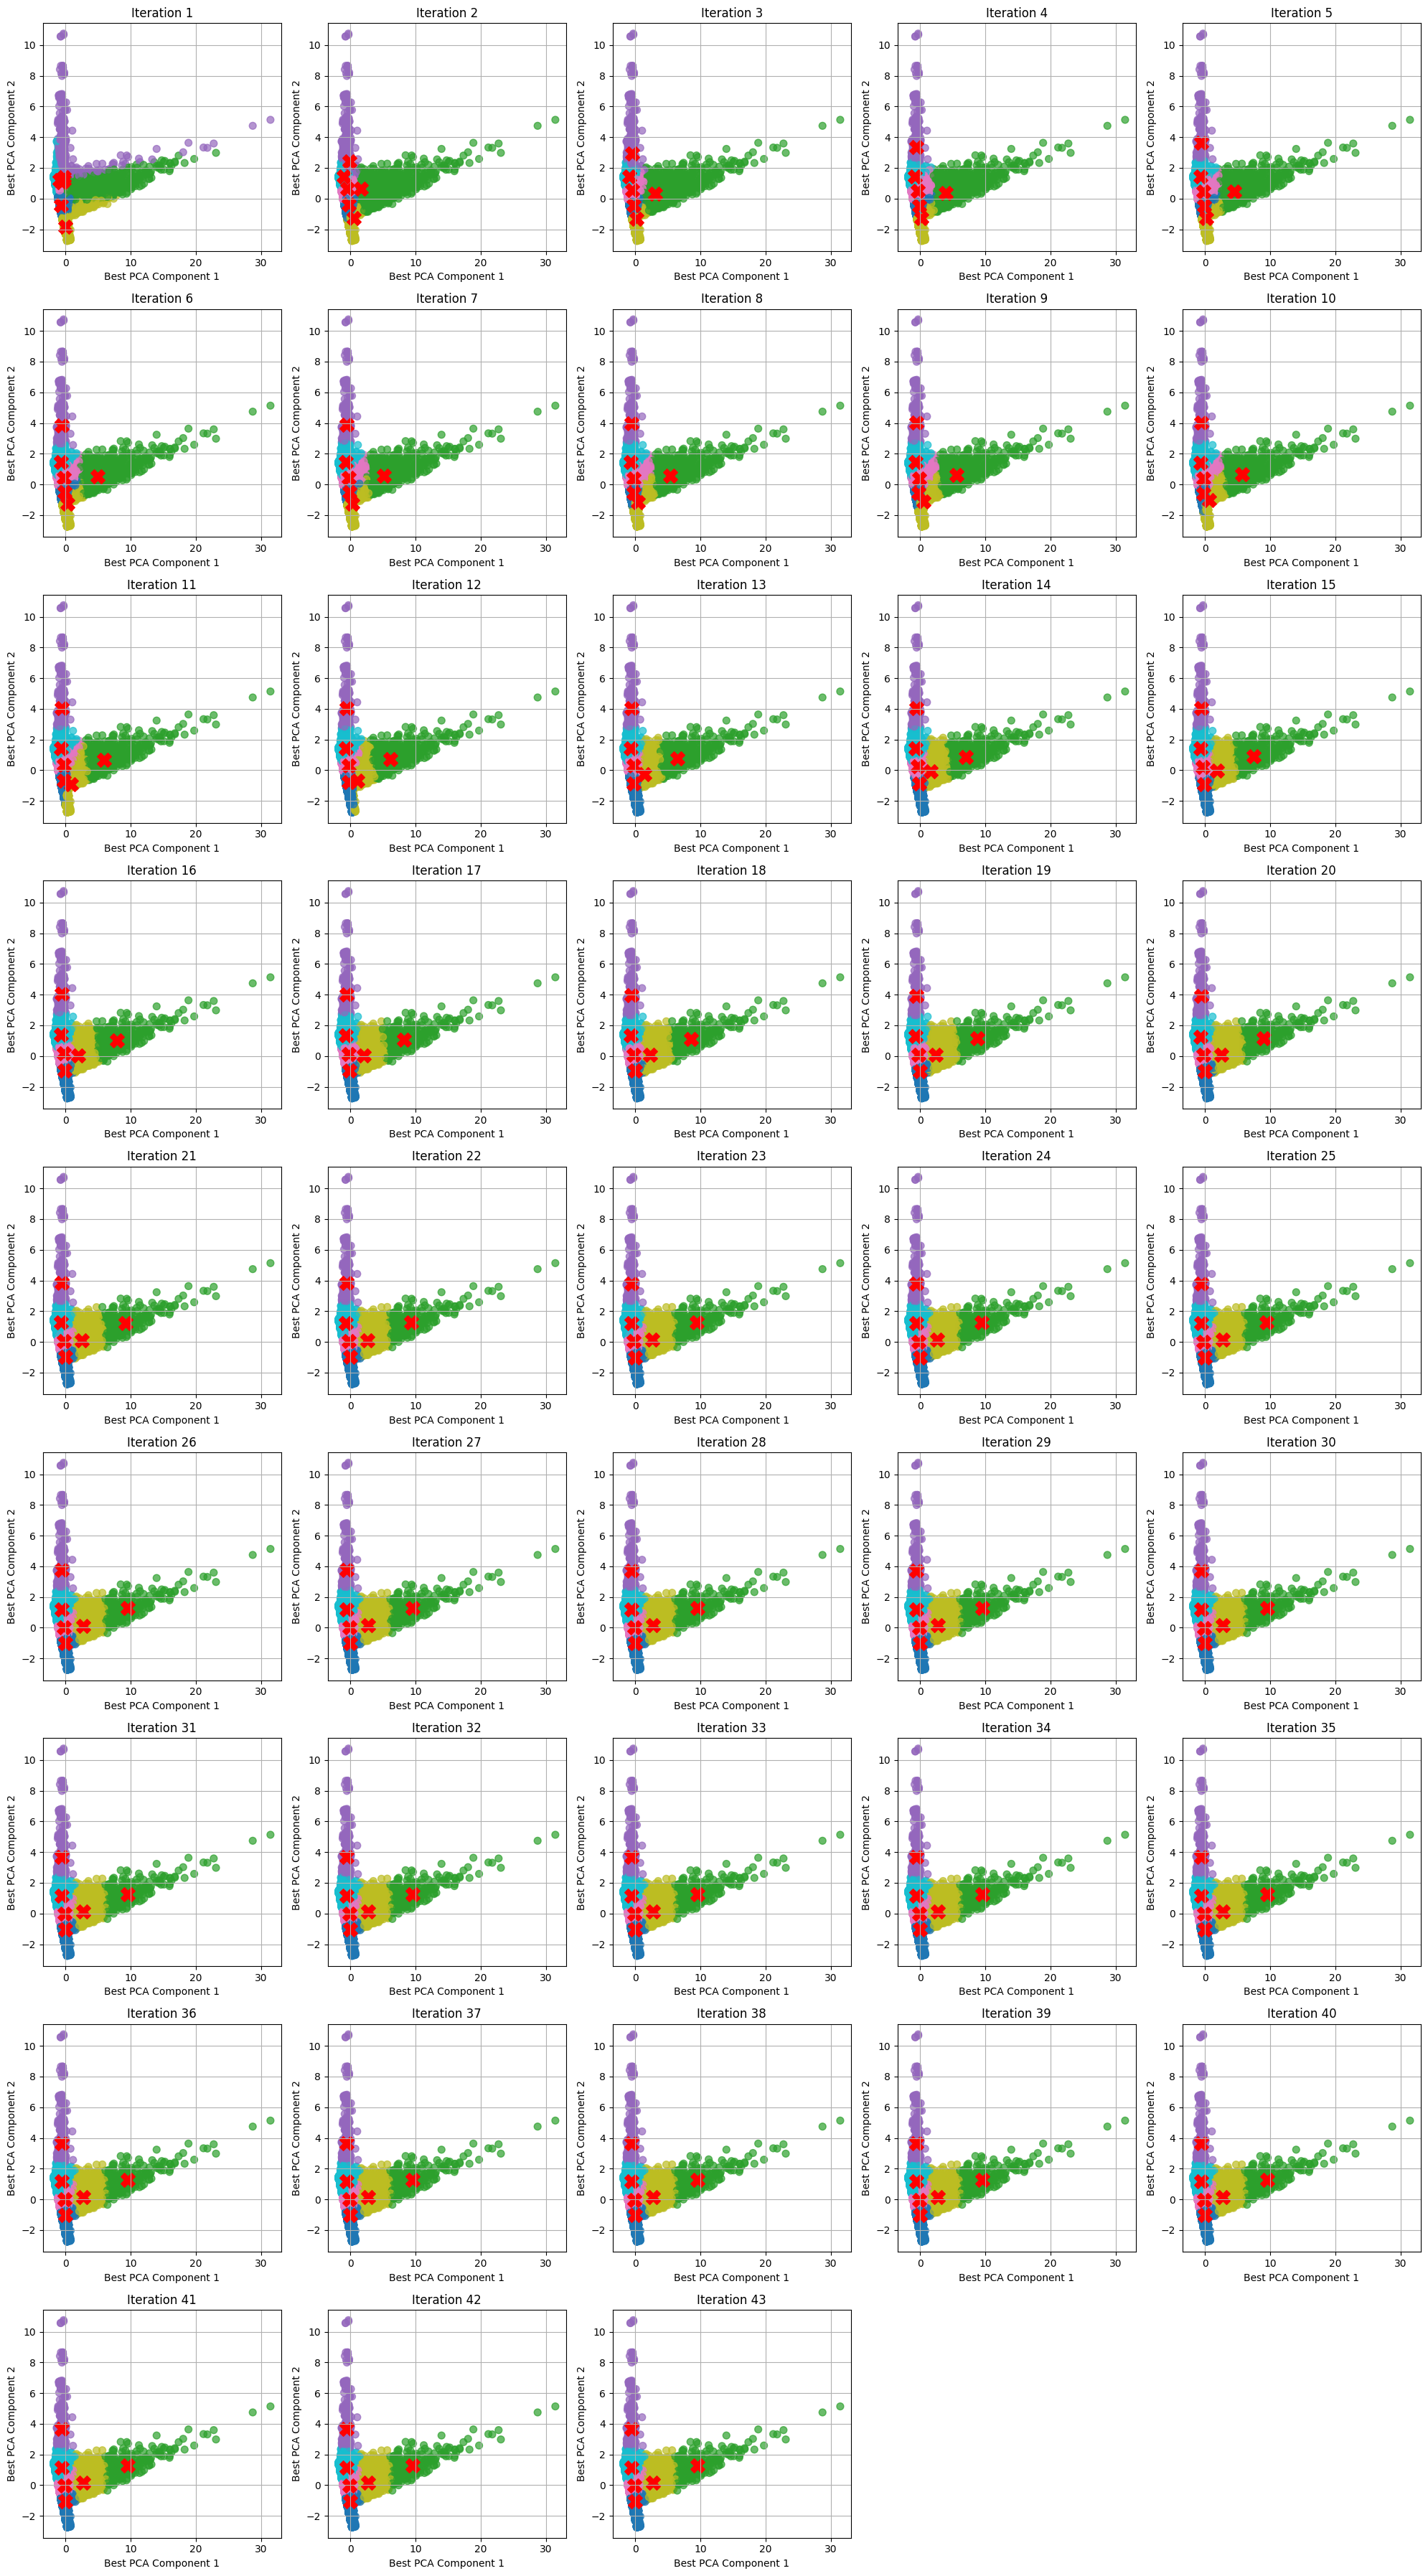

In [58]:
# Apply K-means and track iterations
k_opt = 6  # Optimal number of clusters
iterations = kmeans_visualization(best_pca_data, k_opt, max_iters=50)

# Visualizing the clustering progression
plot_iterations(iterations, best_pca_data)

### 4. Algorithmic Question


Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of nums, is laid out in front of them. Arya will start by selecting either the number at the beginning (nums[0]) or the end (nums[nums.length - 1]) of the array, adding that value to her score. This value is then removed from the beginning or the end of nums. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.

### a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).

Define function `optimal_strategy(nums, start, end, is_arya_turn)`:
  - **Base Case**: 
    - If `start > end`, return 0 (no numbers left).

  - **If `is_arya_turn` (Arya's Turn)**:
    - Option 1: Pick `nums[start]` →  
      `score_if_start = nums[start] + optimal_strategy(nums, start + 1, end, False)`
    - Option 2: Pick `nums[end]` →  
      `score_if_end = nums[end] + optimal_strategy(nums, start, end - 1, False)`
    - Return the maximum of both options:  
      `return max(score_if_start, score_if_end)`

  - **Else (Mario's Turn)**:
    - Option 1: Pick `nums[start]` →  
      `score_if_start = optimal_strategy(nums, start + 1, end, True)`
    - Option 2: Pick `nums[end]` →  
      `score_if_end = optimal_strategy(nums, start, end - 1, True)`
    - Return the minimum of both options:  
      `return min(score_if_start, score_if_end)`


### **Winner Determination Logic**
Define function `can_arya_win(nums)`:
  1. **Calculate Arya's Score**:
     - `arya_score = optimal_strategy(nums, 0, len(nums) - 1, True)`

  2. **Calculate Mario's Score**:
     - `mario_score = sum(nums) - arya_score`

  3. **Compare Scores**:
     - If `arya_score >= mario_score`, return "Arya is the winner."
     - Otherwise, return "Mario is the winner."


In [ ]:
# Recursive Function
def optimal_strategy(nums, start, end, is_arya_turn):
    # Base Case: No numbers left to pick
    if start > end:
        return 0

    if is_arya_turn:  # Arya's Turn (Maximize Score)
        pick_start = nums[start] + optimal_strategy(nums, start + 1, end, False)
        pick_end = nums[end] + optimal_strategy(nums, start, end - 1, False)
        return max(pick_start, pick_end)
    else:  # Mario's Turn (Minimize Arya's Score)
        pick_start = optimal_strategy(nums, start + 1, end, True)
        pick_end = optimal_strategy(nums, start, end - 1, True)
        return min(pick_start, pick_end)


# Determine the Winner
def can_arya_win(nums):
    # Calculate Arya's Score
    arya_score = optimal_strategy(nums, 0, len(nums) - 1, True)
    total_score = sum(nums)
    mario_score = total_score - arya_score

    # Print Results
    print(f"Arya's Score: {arya_score}, Mario's Score: {mario_score}")
    if arya_score >= mario_score:
        print("Arya is the winner!")
    else:
        print("Mario is the winner!")


# Test Cases
test_cases = [
    [3, 9, 1, 2],        # Small array
    [8, 15, 3, 7],       # Tricky array
    [20, 30, 50, 10],    # Larger values
    [1, 5, 233, 7],      # Edge case with a dominant value
    [4, 7, 2, 9, 5, 8],  # Odd-length array
    [2,4,6,6,4,2],       # Tie case
]

# Run Test Cases
for i, nums in enumerate(test_cases):
    print(f"\nTest Case {i+1}: nums = {nums}")
    can_arya_win(nums)



Test Case 1: nums = [3, 9, 1, 2]
Arya's Score: 11, Mario's Score: 4
Arya is the winner!

Test Case 2: nums = [8, 15, 3, 7]
Arya's Score: 22, Mario's Score: 11
Arya is the winner!

Test Case 3: nums = [20, 30, 50, 10]
Arya's Score: 70, Mario's Score: 40
Arya is the winner!

Test Case 4: nums = [1, 5, 233, 7]
Arya's Score: 234, Mario's Score: 12
Arya is the winner!

Test Case 5: nums = [4, 7, 2, 9, 5, 8]
Arya's Score: 24, Mario's Score: 11
Arya is the winner!

Test Case 6: nums = [2, 4, 6, 6, 4, 2]
Arya's Score: 12, Mario's Score: 12
Arya is the winner!


### **c) Is the Algorithm Efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.**

---

# **Is the Algorithm Efficient?**

The algorithm described in the pseudocode **is not efficient**. We will prove that the algorithm has an **exponential time complexity** by analyzing its **recursive structure** and **asymptotic time complexity bound**.

---

## **Proof of Time Complexity**

1. **Recursive Function Calls**:
   - The function `optimal_strategy(nums, start, end, is_arya_turn)` makes **two recursive calls** at each step:
     - Pick the first element `nums[start]`
     - Pick the last element `nums[end]`

2. **Recursion Tree Structure**:
   - Each decision leads to two more function calls, forming a **binary recursion tree**.
   - The **height** of this recursion tree is **N**, where **N** is the length of the array `nums`.

3. **Number of Nodes in the Recursion Tree**:
   - A binary recursion tree of height **N** has approximately **2^N** nodes.
   - This is because at each level, the number of function calls doubles:
   
\[
\text{Total Nodes} = 2^0 + 2^1 + 2^2 + ... + 2^{N-1} \approx 2^N
\]

4. **Work per Node**:
   - Each subproblem performs **O(1)** work (making decisions, comparisons, and returning results).

5. **Total Work Done (Time Complexity)**:
   - The total work is **O(1)** per node multiplied by the total number of nodes **2^N**, resulting in:

\[
T(N) = O(2^N)
\]

---

## **Proof of Space Complexity**

1. **Maximum Recursion Depth**:
   - The maximum recursion depth occurs when the recursion goes all the way from the start to the end of the array. This depth is **N**, the length of the array.

2. **Space Complexity**:
   - Since we only use the recursion stack and no additional data structures, the maximum space required is proportional to the recursion depth:

\[
S(N) = O(N)
\]

---

## **Conclusion: Asymptotic Complexity Bound**
- **Time Complexity**: 

\[
T(N) = O(2^N)
\]

- **Space Complexity**:

\[
S(N) = O(N)
\]

### **Final Statement**
Since the algorithm's recursion tree has **2^N** nodes due to **binary branching**, and each subproblem performs constant work **O(1)**, the total time complexity is **O(2^N)**. The recursion depth contributes to the **space complexity** of **O(N)**.

Thus, the algorithm **requires exponential time** and is **not efficient**.


### **d) If the Algorithm Is Exponential, Explain How to Make It Polynomial and Provide a Pseudocode for It. Recompute the Computational Complexity of the Updated Algorithm.**

---

#### **How to Make the Algorithm Polynomial**

The original algorithm is exponential due to **overlapping subproblems** and **recursive branching**. To make the algorithm **polynomial**, we can use **Dynamic Programming (Memoization)** to store intermediate results and avoid redundant calculations.

---

#### **Updated Approach: Use Memoization Table**

1. **Define a Memoization Table**:
   - Use a 3D table `memo[start][end][turn]`, where:
     - `start` = starting index
     - `end` = ending index
     - `turn` = 1 if it’s Arya's turn, 0 if it’s Mario's turn.

2. **Updated Recursive Formula**:
   - If it’s Arya's turn (`turn = 1`):
     - Arya maximizes her score:
     \[
     \text{memo[start][end][1]} = \max(nums[start] + \text{optimal}(start + 1, end, 0), nums[end] + \text{optimal}(start, end - 1, 0))
     \]

   - If it’s Mario's turn (`turn = 0`):
     - Mario minimizes Arya's score:
     \[
     \text{memo[start][end][0]} = \min(\text{optimal}(start + 1, end, 1), \text{optimal}(start, end - 1, 1))
     \]

3. **Base Case**:
   - If `start > end`, return 0 (no numbers left).

---



## **Updated Pseudocode with Memoization**

```markdown
Define function `optimal_strategy(nums, start, end, is_arya_turn)`:
  - **Base Case**: 
    - If `start > end`, return 0.

  - **If the result is already computed**:
    - Return `memo[start][end][is_arya_turn]`.

  - **If `is_arya_turn == True` (Arya's Turn)**:
    - Pick the first element `nums[start]`:  
      `score_if_start = nums[start] + optimal_strategy(nums, start + 1, end, False)`
    - Pick the last element `nums[end]`:  
      `score_if_end = nums[end] + optimal_strategy(nums, start, end - 1, False)`
    - Store the maximum of both options:  
      `memo[start][end][1] = max(score_if_start, score_if_end)`

  - **Else (Mario's Turn)**:
    - Pick the first element `nums[start]`:  
      `score_if_start = optimal_strategy(nums, start + 1, end, True)`
    - Pick the last element `nums[end]`:  
      `score_if_end = optimal_strategy(nums, start, end - 1, True)`
    - Store the minimum of both options:  
      `memo[start][end][0] = min(score_if_start, score_if_end)`

  - **Return the computed result**:
    - Return `memo[start][end][is_arya_turn]`.

Define function `can_arya_win(nums)`:
  1. **Initialize memoization table**:
     - `memo = [[[None for _ in range(2)] for _ in range(len(nums))] for _ in range(len(nums))]`
  2. **Calculate Arya's Score**:
     - `arya_score = optimal_strategy(nums, 0, len(nums) - 1, True)`
  3. **Calculate Mario's Score**:
     - `mario_score = sum(nums) - arya_score`
  4. **Determine the Winner**:
     - If `arya_score >= mario_score`, return "Arya is the winner."
     - Else, return "Mario is the winner."


# **Recomputed Computational Complexity**

---

### **Time Complexity Analysis**

1. **Number of Subproblems**:
   - We use a 3D memoization table `memo[start][end][turn]`, where:
     - `start` can take values from `0` to `N - 1`.
     - `end` can take values from `0` to `N - 1`.
     - `turn` can be `0` (Mario's turn) or `1` (Arya's turn).

   Thus, the **total number of subproblems** is:

\[
\text{Total Subproblems} = 2 \times N^2 = O(N^2)
\]

2. **Work Done per Subproblem**:
   - Each subproblem involves **O(1)** work for choosing between two options and storing the result.

Thus, the **time complexity** is:

\[
T(N) = O(N^2)
\]

---

### **Space Complexity Analysis**

1. **Memoization Table**:
   - The space required for storing the table `memo[start][end][turn]` is:

\[
S(N) = O(N^2)
\]

2. **Call Stack Space**:
   - Since the maximum recursion depth is **N**, the recursion call stack contributes an additional:

\[
S(N) = O(N)
\]

Thus, the **total space complexity** becomes:

\[
S(N) = O(N^2)
\]

---

## **Final Answer: Asymptotic Complexity Bound**

- **Time Complexity**: 

\[
T(N) = O(N^2)
\]

- **Space Complexity**:

\[
S(N) = O(N^2)
\]

---

### **Conclusion**
By introducing **dynamic programming (memoization)**, we reduce the **time complexity** from **exponential O(2^N)** to **polynomial O(N²)**. The **space complexity** also becomes **O(N²)** due to storing intermediate results. This makes the algorithm **efficient** and feasible for large input sizes.


### e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.

In [70]:
import time

# Exponential Algorithm (Without Memoization)
def optimal_strategy_exp(nums, start, end, is_arya_turn):
    if start > end:
        return 0

    if is_arya_turn:  # Arya's Turn
        pick_start = nums[start] + optimal_strategy_exp(nums, start + 1, end, False)
        pick_end = nums[end] + optimal_strategy_exp(nums, start, end - 1, False)
        return max(pick_start, pick_end)
    else:  # Mario's Turn
        pick_start = optimal_strategy_exp(nums, start + 1, end, True)
        pick_end = optimal_strategy_exp(nums, start, end - 1, True)
        return min(pick_start, pick_end)


# Optimized Algorithm (With Memoization)
def optimal_strategy_memo(nums, start, end, is_arya_turn, memo):
    if start > end:
        return 0

    if memo[start][end][is_arya_turn] is not None:
        return memo[start][end][is_arya_turn]

    if is_arya_turn:  # Arya's Turn (Maximize Score)
        pick_start = nums[start] + optimal_strategy_memo(nums, start + 1, end, 0, memo)
        pick_end = nums[end] + optimal_strategy_memo(nums, start, end - 1, 0, memo)
        result = max(pick_start, pick_end)
    else:  # Mario's Turn (Minimize Arya's Score)
        pick_start = optimal_strategy_memo(nums, start + 1, end, 1, memo)
        pick_end = optimal_strategy_memo(nums, start, end - 1, 1, memo)
        result = min(pick_start, pick_end)

    memo[start][end][is_arya_turn] = result
    return result


# Comparison Function
def compare_algorithms(nums):
    # Measure Exponential Algorithm
    start_time = time.perf_counter()
    arya_score_exp = optimal_strategy_exp(nums, 0, len(nums) - 1, True)
    exp_time = time.perf_counter() - start_time

    # Measure Memoized Algorithm
    memo = [[[None for _ in range(2)] for _ in range(len(nums))] for _ in range(len(nums))]
    start_time = time.perf_counter()
    arya_score_memo = optimal_strategy_memo(nums, 0, len(nums) - 1, 1, memo)
    memo_time = time.perf_counter() - start_time

    total_score = sum(nums)
    mario_score_exp = total_score - arya_score_exp
    mario_score_memo = total_score - arya_score_memo

    print(f"\nTesting nums: {nums}")
    print(f"Exponential Algorithm: Arya's Score: {arya_score_exp}, Mario's Score: {mario_score_exp}, Time: {exp_time:.5f}s")
    print(f"Memoized Algorithm: Arya's Score: {arya_score_memo}, Mario's Score: {mario_score_memo}, Time: {memo_time:.5f}s")


# Test Cases
test_cases = [
    [3, 9, 1, 2],        # Small array
    [8, 15, 3, 7],       # Tricky array
    [20, 30, 50, 10],    # Larger values
    [1, 5, 233, 7],      # Edge case with a dominant value
    [4, 7, 2, 9, 5, 8],  # Odd-length array
]

# Run Test Cases
for nums in test_cases:
    compare_algorithms(nums)



Testing nums: [3, 9, 1, 2]
Exponential Algorithm: Arya's Score: 11, Mario's Score: 4, Time: 0.00001s
Memoized Algorithm: Arya's Score: 11, Mario's Score: 4, Time: 0.00001s

Testing nums: [8, 15, 3, 7]
Exponential Algorithm: Arya's Score: 22, Mario's Score: 11, Time: 0.00002s
Memoized Algorithm: Arya's Score: 22, Mario's Score: 11, Time: 0.00001s

Testing nums: [20, 30, 50, 10]
Exponential Algorithm: Arya's Score: 70, Mario's Score: 40, Time: 0.00001s
Memoized Algorithm: Arya's Score: 70, Mario's Score: 40, Time: 0.00001s

Testing nums: [1, 5, 233, 7]
Exponential Algorithm: Arya's Score: 234, Mario's Score: 12, Time: 0.00001s
Memoized Algorithm: Arya's Score: 234, Mario's Score: 12, Time: 0.00001s

Testing nums: [4, 7, 2, 9, 5, 8]
Exponential Algorithm: Arya's Score: 24, Mario's Score: 11, Time: 0.00003s
Memoized Algorithm: Arya's Score: 24, Mario's Score: 11, Time: 0.00001s


#### f.  The exponential algorithm and the memoized algorithm produce the same correct results for all test cases, confirming the correctness of both implementations. However, the running time comparison highlights the efficiency of the memoized algorithm, which consistently performs faster due to its polynomial time complexity (O(N²)), while the exponential algorithm (O(2^N)) slows down as input size increases. This demonstrates that using dynamic programming (memoization) drastically improves performance, making the algorithm scalable for larger inputs.

# **Time Complexity Analysis**

### **1. Time Complexity**:
- **Tree Depth**: **N** (since the game progresses by removing one element at each move).
- **Branching Factor**: **2** (since we have two options: start or end).
  
Thus, the **time complexity** becomes:  

\[
T(N) = O(2^N)
\]

**Why Not Polynomial?**  
Even with **Alpha-Beta Pruning**, the worst-case time complexity remains **O(2^N)** due to exploring the entire game tree. However, **pruning irrelevant branches** significantly improves practical performance.

---

### **2. Space Complexity**:  
- **Recursion Call Stack Depth**: **O(N)** due to the maximum depth of recursion when processing the entire array.

Thus, the **space complexity** is:  

\[
S(N) = O(N)
\]

---

# **Evaluation of LLM's Suggested Algorithm**

### **1. Correctness**:  
- The suggested algorithm **Minimax with Alpha-Beta Pruning** ensures **correct outputs** similar to the memoized version.

### **2. Efficiency Comparison**:  
- Though it has a theoretical **time complexity of O(2^N)**, the algorithm **prunes unnecessary branches**, reducing the **practical runtime** considerably.

### **3. Evaluation Criteria**:  
- **Correct Results Comparison**: Compare scores with the memoized version to validate the correctness.
- **Time Profiling**: Measure runtime across various test cases to assess the performance.
- **Test Edge Cases**: Check special cases like ties, small arrays, and maximum recursion depths to ensure consistency.

---

# **Final Conclusion**  
The LLM **provided a valid and optimized approach** using **Minimax with Alpha-Beta Pruning**. While the theoretical **time complexity remains exponential**, the **practical performance** is significantly improved. This demonstrates the LLM's ability to suggest advanced algorithms and **optimize game-solving strategies** effectively.
